In [60]:
import pandas as pd
import geopandas as gpd
import graph_tool.all as gt
from matplotlib import pyplot
from shapely.geometry import Point, LineString
import numpy
import seaborn as sns
sns.set()
%matplotlib inline
pd.set_option('display.max_rows', 20)

In [81]:
df = pd.read_pickle('../../policosm/classes/test_graph_edges.pkl')

In [82]:
df

,u,v,path,osm_id,highway,level,lanes,width,bicycle,bicycle_safety,foot,foot_safety,max_speed,motorcar
edge_id,,,,,,,,,,,,,,
561947,382017,505820717,"[382017, 505820717]",34855904,primary,6,1,3.0,1,0,1,0,50,1
696802,382017,5467645823,"[382017, 5467645823]",41361996,footway,2,1,1.5,0,-1,1,1,30,0
3186841,382017,3745434708,"[382017, 3745434701, 1836953770, 3745434708]",2569,tertiary,4,1,3.0,1,0,1,0,50,1
3326751,382017,3745434703,"[382017, 3745434699, 1836953768, 3745434703]",40001847,secondary,5,1,3.0,1,0,1,0,50,1
3631372,382017,1756468207,"[382017, 3745434692, 1756468207]",370869408,footway,2,1,1.5,0,-1,1,1,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186823,7237549021,7237549020,"[7237549021, 7237549020]",775815846,service,2,1,1.5,1,1,1,1,-1,1
3186826,7237578021,7237578022,"[7237578021, 7237578022]",775816896,service,2,1,1.5,1,1,1,1,-1,1
3793562,7237651823,7237651825,"[7237651823, 7237651824, 7237651825]",775822613,service,2,1,1.5,1,1,1,1,-1,1


In [115]:
df['line'] = df.path.apply(lambda p:[geoms.get(x) for x in p])
df['path'] = df.line.apply(LineString)

In [107]:
g = gt.Graph(directed=True)

osm_id = g.new_edge_property('string')
highway = g.new_edge_property('string')
level = g.new_edge_property('int')
lanes = g.new_edge_property('int')
width = g.new_edge_property('float')
bicycle = g.new_edge_property('bool')
bicycle_safety = g.new_edge_property('int')
foot = g.new_edge_property('bool')
foot_safety = g.new_edge_property('int')
max_speed = g.new_edge_property('int')

edgelist = df[['u','v','osm_id','highway','level','lanes','width','bicycle','bicycle_safety','foot','foot_safety','max_speed']].values

In [66]:
# keep nodes_id as it reference the nodes from osm
nodes_id = g.add_edge_list(edgelist, hashed=True, eprops=[osm_id, highway,level,lanes,width,bicycle,bicycle_safety,foot,foot_safety,max_speed])

In [67]:
#for node in range(g.num_vertices()):
    #print("Node {} has id: {}".format(node, nodes_id[node]))

In [68]:
e_colors = g.new_edge_property('string')
for e in g.edges():
    e_colors[e] = 'g'

e_linestring = g.new_ep('vector<int64_t>')
for e in g.edges():
    e_linestring[e] = []
    
vs = g.get_vertices()
in_deg_2 = g.get_in_degrees(vs)==2
out_deg_2 = g.get_out_degrees(vs)==2
in_out_deg_2 = in_deg_2 & out_deg_2

candidates = set()
for i,v in enumerate(vs):
    if in_out_deg_2[i]:
        ns = list(set(g.get_all_neighbors(v)))
        
        if len(ns) == 2:
            u,w = ns[0], ns[1]
            uv, vw, wv, vu = g.edge(u,v), g.edge(v,w), g.edge(w,v), g.edge(v,u)
            if highway[uv] == highway[vw] and highway[wv] == highway[vu]:
                candidates.add(v)

candidates = set(candidates)
seen = set()
unregister_candidates = set()

for candidate in candidates:
    if candidate in seen:
        continue
    
    seen.add(candidate)
   
    u, w = g.get_out_neighbors(candidate)
    highway_cu, highway_cw = highway[g.edge(candidate,u)], highway[g.edge(candidate,w)]
    is_u_fringe, is_w_fringe = u not in candidates, w not in candidates

    us = []
    ws = []
        
    while not is_u_fringe:
        seen.add(u)
        us.append(u)
        neighbors = set(g.get_out_neighbors(u))
        neighbors -= seen
        if len(neighbors) > 0:
            u = neighbors.pop()
            is_u_fringe = u not in candidates
        elif u == w:
            us.pop(-1)
            u = us.pop(-1)
            unregister_candidates.add(u)
            unregister_candidates.add(w)
            is_u_fringe = True
            is_w_fringe = True
            g.remove_edge(g.edge(s=u,t=w))
            g.remove_edge(g.edge(s=w,t=u))
        else:
            break
    
    while not is_w_fringe:
        seen.add(w)
        ws.append(w)
        neighbors = set(g.get_out_neighbors(w))
        neighbors -= seen
        if len(neighbors) > 0:
            w = neighbors.pop()
            is_w_fringe = w not in candidates
        else:
            break
            
    if is_u_fringe and is_w_fringe:       
        e = g.add_edge(source=u, target=w)
        highway[e] = highway_cw
        path = [u] + list(reversed(us)) + [candidate] + ws + [w]
        e_linestring[e] = [int(nodes_id[node]) for node in path]
        e_colors[e] = 'r'
        
        e = g.add_edge(source=w, target=u)
        highway[e] = highway_cu
        path = [w] + list(reversed(ws)) + [candidate] + us + [u]
        e_linestring[e] = [int(nodes_id[node]) for node in path]
        e_colors[e] = 'r'

    else:
        print('unexpected behavior, source={0}, target={1}, candidate={2}, us={3}, ws={4}', u, w, us, ws)

unseen = candidates - seen
if len(unseen) > 0:
    print('Network scan for simplification uncomplete: {1} have not been seen'.format(unseen) )
    

candidates -= unregister_candidates
g.remove_vertex(list(candidates))
    
v_colors = g.new_vertex_property('string')
for v in g.vertices():
    v_colors[v] = 'r' if v in candidates else 'b'
#g.vertex_properties["color"]  = v_colors
#colors = g.vertex_properties["color"]

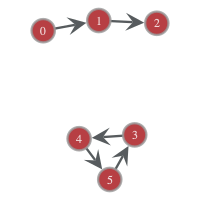

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x16132b9d0, at 0x161d79ed0>

In [69]:

g2 = gt.Graph(directed=True)
v1 = g2.add_vertex()
v2 = g2.add_vertex()
v3 = g2.add_vertex()
e1 = g2.add_edge(v1, v2)
e2 = g2.add_edge(v2, v3)

v4 = g2.add_vertex()
v5 = g2.add_vertex()
v6 = g2.add_vertex()
e3 = g2.add_edge(v4, v5)
e4 = g2.add_edge(v5, v6)
e5 = g2.add_edge(v6, v4)

highway2 = g2.new_edge_property('string')
for e in g2.edges():
    highway2[e] = 'road'

gt.graph_draw(g2, vertex_text=g2.vertex_index, vertex_font_size=12,output_size=(200, 200))

[0 1 1 1 1 1]
[False  True False  True  True  True]
0 1 2
5 3 4
3 4 5
4 5 3
{1, 3, 4, 5}
[0, 1, 2]
[5, 3, 4]


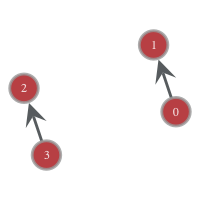

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x16132b9d0, at 0x1615c2ed0>

In [70]:
vs = g2.get_vertices()
print(g2.get_in_degrees(vs))

in_deg_1 = g2.get_in_degrees(vs)==1
out_deg_1 = g2.get_out_degrees(vs)==1
in_out_deg_1 = in_deg_1 & out_deg_1
print(in_out_deg_1)
candidates = set()
for i,v in enumerate(vs):
    if in_out_deg_1[i]:
        u = g2.get_in_neighbors(v)[0]
        w = g2.get_out_neighbors(v)[0]
        print(u, v, w)
        if u != w:
            uv, vw = g2.edge(u,v), g2.edge(v,w)
            if highway2[uv] == highway2[vw]:
                candidates.add(v)
print(candidates)
candidates = set(candidates)
seen = set()
unregister_candidates = set()

for candidate in candidates:
    if candidate in seen:
        continue
    
    seen.add(candidate)
   
    u = g2.get_in_neighbors(candidate)[0]
    w = g2.get_out_neighbors(candidate)[0]

    highway_uc = highway[g2.edge(u,candidate)]
    is_u_fringe, is_w_fringe = u not in candidates, w not in candidates

    us = []
    ws = []
        
    while not is_u_fringe:
        seen.add(u)
        us.append(u)
        neighbors = set(g2.get_in_neighbors(u))
        neighbors -= seen
        if len(neighbors) > 0:
            u = neighbors.pop()
            is_u_fringe = u not in candidates
        elif u == w:
            us.pop(-1)
            u = us.pop(-1)
            unregister_candidates.add(u)
            unregister_candidates.add(w)
            is_u_fringe = True
            is_w_fringe = True
            g2.remove_edge(g2.edge(s=w,t=u))
        else:
            break
    
    while not is_w_fringe:
        seen.add(w)
        ws.append(w)
        neighbors = set(g2.get_out_neighbors(w))
        neighbors -= seen
        if len(neighbors) > 0:
            w = neighbors.pop()
            is_w_fringe = w not in candidates
        else:
            break
            
    if is_u_fringe and is_w_fringe:       
        e = g2.add_edge(source=u, target=w)
        highway[e] = highway_uc
        path = [u] + list(reversed(us)) + [candidate] + ws + [w]
        print(path)
#        e_linestring[e] = [int(nodes_id[node]) for node in path]

    else:
        print('unexpected behavior, source={0}, target={1}, candidate={2}, us={3}, ws={4}', u, w, us, ws)

unseen = candidates - seen
if len(unseen) > 0:
    print('Network scan for simplification uncomplete: {1} have not been seen'.format(unseen) )
    

candidates -= unregister_candidates
g2.remove_vertex(list(candidates))
gt.graph_draw(g2, vertex_text=g2.vertex_index, vertex_font_size=12,output_size=(200, 200))

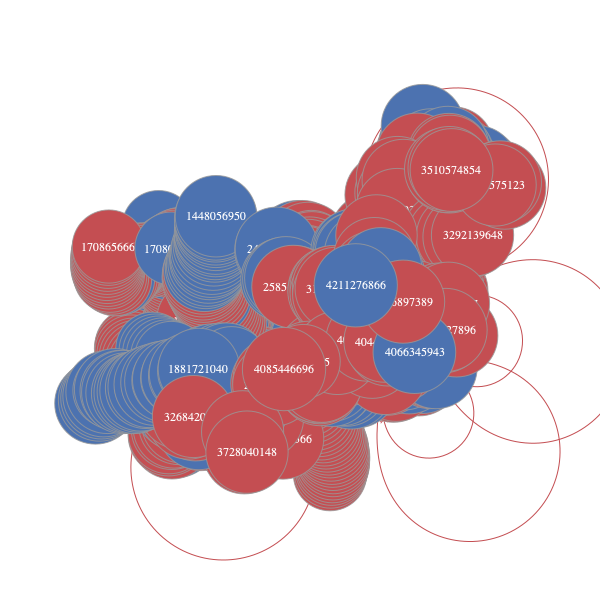

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x16132be10, at 0x1436adb90>

In [71]:
v_prop = g.new_vertex_property('string')
for v in g.get_vertices():
    v_prop[v] = str(nodes_id[v])

#gt.graph_draw(g,vertex_size=10, vertex_fill_color=v_colors)

gt.graph_draw(g,vertex_size=10, vertex_text=v_prop, vertex_fill_color=v_colors, edge_color=e_colors)

In [222]:
m
df2

,u,v,path,osm_id,highway,one_way,level,lanes,width,bicycle,bicycle_safety,foot,foot_safety,max_speed
edge_id,,,,,,,,,,,,,,
0,25933136,1025046800,"[25933136, 1025046800]",4385908,primary,True,6,1,3.0,True,0,True,0,None
46,25933136,1025046804,"[25933136, 1025046804]",4385908,cycleway,True,2,1,1.5,True,0,False,0,30
47,25933136,1025046804,"[25933136, 1025046804]",4385908,cycleway,True,2,1,1.5,True,0,False,0,30
2429,25933136,62020172,"[25933136, 62020172]",11654187,tertiary,False,4,2,6.0,True,0,True,0,None
1,1025046800,25933136,"[1025046800, 25933136]",4385908,cycleway,True,2,1,1.5,True,0,False,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15676,4085446696,4085446718,"[4085446696, 4085446699, 4085446705, 408544671...",406480217,service,False,2,1,3.0,False,-1,False,-1,None
15677,4085446696,4085446696,"[4085446696, 4085446692, 4085446690, 408544658...",406480217,service,False,2,1,3.0,False,-1,False,-1,None
15678,4085446696,4085446696,"[4085446696, 4085446700, 4085446702, 408544670...",406480217,service,False,2,1,3.0,False,-1,False,-1,None


In [84]:
dfv = pd.read_pickle('../../policosm/classes/test_graph_vertices.pkl')
dfv = gpd.GeoDataFrame(dfv, geometry='geometry')
dfv.crs = "EPSG:3949"
#dfv.plot(figsize=(26, 20), marker='o', markersize=0.7)
dfv.head()

,longitude,latitude,geometry
osm_id,,,
122642,2.526919,49.006576,POINT (1665391.524 8200839.099)
122922,2.440223,48.875346,POINT (1658941.760 8186290.005)
122923,2.446231,48.878239,POINT (1659384.763 8186608.416)
122924,2.457584,48.883178,POINT (1660221.331 8187151.654)
122925,2.459886,48.884005,POINT (1660390.853 8187242.364)


In [85]:
dfv2 = dfv.sample(n=30)

In [92]:
geoms = dict(zip(dfv.index.to_list(), dfv['geometry'].to_list()))

14930892


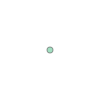

In [95]:
geoms.get(122925)

In [267]:
errors = []
def create_linestrings(path):
    global errors
    try:
        path_geo = LineString([dfv['geometry'].loc[s] for s in path if s in osm_ids])
    except KeyError as err:
        # print('node does not exist in {0}, error {1}'.format(path, err))
        return None
    except ValueError as err:
        # print('linestring too short with {0}, error {1}'.format(path, err))
        errors += [(dfv['geometry'].loc[s].x, dfv['geometry'].loc[s].y) for s in path if s in osm_ids]
        return None
    return path_geo
#print(errors)
df2['linestring'] = df2['path'].apply(create_linestrings)

In [275]:
dferrors = pd.DataFrame.from_records(errors,columns=['x','y'])
dferrors = dferrors.apply(pd.to_numeric)
gdferrors = gpd.GeoDataFrame(dferrors, geometry=gpd.points_from_xy(dferrors.x,dferrors.y))
gdferrors.crs = 'EPSG:3946'

In [116]:
gdf2 = gpd.GeoDataFrame(df, geometry='path')
gdf2.crs = "EPSG:3949"

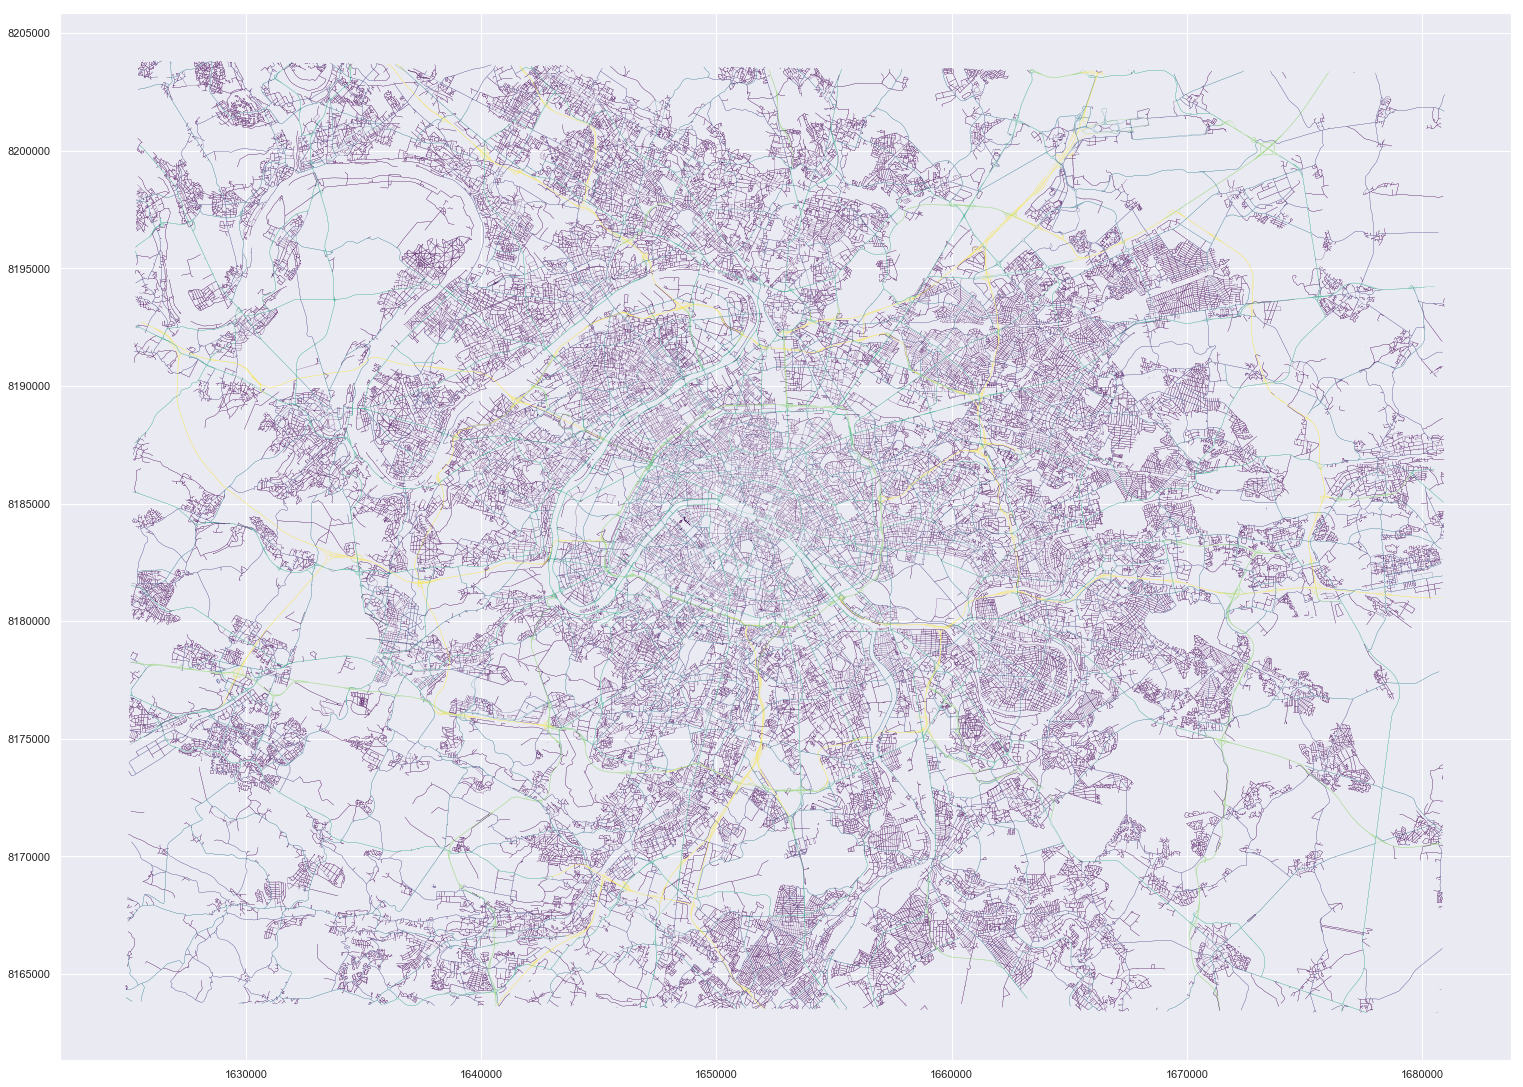

In [125]:
#fig, ax = pyplot.subplots()
plot = gdf2.loc[gdf2.level >=3].plot(column='level',cmap='viridis', linewidth=0.2, figsize=(26, 26))
#plot = gdferrors.plot(marker='o',color='red',alpha=0.7,markersize=5,ax=ax)
fig = plot.get_figure()
fig.savefig("paris-graph-level3.pdf",dpi=100)

In [123]:
gdf2['length'] = gdf2.geometry.length

In [124]:
 gdf2.head(n=2)

,u,v,path,osm_id,highway,level,lanes,width,bicycle,bicycle_safety,foot,foot_safety,max_speed,motorcar,line,length
edge_id,,,,,,,,,,,,,,,,
561947,382017,505820717,"LINESTRING (1653700.628 8180346.831, 1653724.9...",34855904,primary,6,1,3.0,1,0,1,0,50,1,"[POINT (1653700.628155321 8180346.830564086), ...",26.993232
696802,382017,5467645823,"LINESTRING (1653700.628 8180346.831, 1653707.1...",41361996,footway,2,1,1.5,0,-1,1,1,30,0,"[POINT (1653700.628155321 8180346.830564086), ...",11.090568
